# 以下テンプレート

In [1]:
# 表示用
from tqdm import tqdm
from tqdm import tnrange, tqdm_notebook

In [2]:
import numpy as np
import datetime
import os
import copy

# Parametor about Sensor
SensorNum=1 # Sensor number
#SensorAxis='AccX' # Axis

# Define Data Name
DATE= str( datetime.date.today() )+'/'
TITLE="Participants01_First_1/"
Label = ['LeftHand','RightHand','LeftLeg','Rightleg','West','Chest']

# Parametor about " Data Path"
DataPath = "/media/takeyama/Transfer/02_ActivityResearch/Paticipants01/01_First/20161018-105301/mem/"
StorePath = "/media/takeyama/Transfer/02_ActivityResearch/"

if not os.path.exists(StorePath+TITLE+'dictionary/'): 
    os.makedirs(StorePath+TITLE+'dictionary/')
DictionaryDataPath=StorePath+TITLE+'dictionary/'

if not os.path.exists(StorePath+TITLE+'window/'): 
    os.makedirs(StorePath+TITLE+'window/')
WindowDataPath=StorePath+TITLE+'window/'

if not os.path.exists(StorePath+TITLE+DATE+'studyOutput/'): 
    os.makedirs(StorePath+TITLE+DATE+'studyOutput/')
StudyOutputPath=StorePath+TITLE+DATE+'studyOutput/'

if not os.path.exists(StorePath+TITLE+DATE+'parametor/'): 
    os.makedirs(StorePath+TITLE+DATE+'parametor/')
ParametorPath=StorePath+TITLE+DATE+'parametor/'

if not os.path.exists(StorePath+TITLE+DATE+'result/'): 
    os.makedirs(StorePath+TITLE+DATE+'result/')
ResultPath=StorePath+TITLE+DATE+'result/'

if not os.path.exists(StorePath+TITLE+DATE+'graph/'): 
    os.makedirs(StorePath+TITLE+DATE+'graph/')
GraphPath=StorePath+TITLE+DATE+'graph/'

**センサデータの読み込み**

In [3]:
# センサデータのcsvファイル名をリストに集約する関数
def SensorDataFileNameList(path):
    l = os.listdir(DataPath)
    FilePath =[]
    SensorName = []
    
    for n in range(len(l)):
        if (l[n][:4].find('mem-') != -1):
            FilePath.append(l[n])
            SensorName.append(l[n][4:15])
    
    return FilePath,SensorName

CSVを読み込んで，CSVの中身を辞書型で表現する．

In [4]:
def ImportCSV(csv_file,SensorName,mode='Round'):
    import pandas as pd
    '''
    ~Argument~
    csv_file -> ファイル名 
    mode Round -> 四捨五入
         Roundup -> 切り上げ
         Rounddown -> 切り捨て
    
    ~Conversion~
    Acc Data  [0.1mG]=>[G]
    Gyr Data  [0.01dps]=>[dps]   ...dps=degree per second
    '''
    # data dictionary 
    RawData={}   
    AccConversion = 0.1 * 0.001
    GyrConversion = 0.01
    
    # design dataframe and import csv
    data = pd.read_csv(csv_file)
    data.columns=[u'Type',u'Time',u'AccX',u'AccY',u'AccZ',u'GyrX',u'GyrY',u'GyrZ']
    data = data[ data['Type']=='ags']

    # convert numpy.darray 

    AccX=data.AccX.values*AccConversion
    AccY=data.AccY.values*AccConversion
    AccZ=data.AccZ.values*AccConversion
    
    GyrX=data.GyrX.values*GyrConversion
    GyrY=data.GyrY.values*GyrConversion
    GyrZ=data.GyrZ.values*GyrConversion

    # regist each raw data 
    RawData['AccX'] = AccX
    RawData['AccY'] = AccY
    RawData['AccZ'] = AccZ
    RawData['GyrX'] = GyrX
    RawData['GyrY'] = GyrY
    RawData['GyrZ'] = GyrZ
    RawData['Name'] = SensorName

    RawData['Time'] = data.Time.values

    return RawData

In [5]:
# FFT library
from scipy import fftpack
from scipy import signal

# Graph Plot
import matplotlib.pyplot as plt

# Generate WindowFrame Function
from mymodule import window

# timer
import time

%matplotlib inline

In [6]:
from keras.models import Sequential
from keras.datasets import cifar10
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import SGD, Adadelta, Adagrad, Adam, Adamax, RMSprop, Nadam
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils.visualize_util import model_to_dot, plot
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import regularizers

import matplotlib.image as mpimg


Using Theano backend.
Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5005)


**Phase1 計測データの取得**

ここで行うことは，学習に用いるnpzファイルを読み込む

In [7]:
print DictionaryDataPath

/media/takeyama/Transfer/02_ActivityResearch/Participants01_First_1/dictionary/


In [8]:
DictName=os.listdir(DictionaryDataPath)
print DictName

['Chest.npz', 'LeftHand.npz', 'LeftLeg.npz', 'RightHand.npz', 'Rightleg.npz', 'West.npz']


In [9]:
Sensor1 = np.load(DictionaryDataPath+DictName[0])['data'][()]
Sensor2 = np.load(DictionaryDataPath+DictName[1])['data'][()]
Sensor3 = np.load(DictionaryDataPath+DictName[2])['data'][()]
Sensor4 = np.load(DictionaryDataPath+DictName[3])['data'][()]
Sensor5 = np.load(DictionaryDataPath+DictName[4])['data'][()]
Sensor6 = np.load(DictionaryDataPath+DictName[5])['data'][()]

**Phase2 window flame 作成 & Learning**

In [10]:
def SparseAutoEncoder(TrainWindow,TestWindow,dim,opt,cname,\
                      batchSize,weightL1=10e-5,weightL2=0.0):
    """
    TrainWindow: 訓練データ
    TestWindow: テストデータ
    dim: 中間層の次元数
    opt: 最適化関数
    cname: 各種データを保存する用の共通の名前
    """
    input_img = Input(shape=( TrainWindow.shape[1],))
    
    encoded = Dense(dim, activation='tanh',\
                W_regularizer=regularizers.WeightRegularizer(l1=weightL1,l2=weightL2)\
                   )(input_img)
    decoded = Dense( TrainWindow.shape[1] , activation='linear')(encoded)
    autoencoder = Model(input=input_img, output=decoded)
    
    encoder = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=opt, loss='mse')

    #plot(autoencoder,  to_file=StudyDataModelPicPath+SaveFileNameNet+'.png')
    
    #early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    hist = autoencoder.fit(TrainWindow, TrainWindow,
                    nb_epoch=50,
                    verbose=2,
                    batch_size=batchSize,
                    shuffle=False,
                    validation_data=(TestWindow, TestWindow)
                    #callbacks=[early_stopping]
                          )
    time.sleep(0.1)

    encoded_imgs = encoder.predict(TrainWindow,batch_size=batchSize,verbose=1)
    print "encoded_imgs.shape="+str(encoded_imgs.shape)
    decoded_imgs = decoder.predict(encoded_imgs,batch_size=batchSize,verbose=1)

    np.savez(StudyOutputPath+cname+'_Encoded',data=encoded_imgs)
    np.savez(StudyOutputPath+cname+'_Decoded',data=decoded_imgs)

    # save model and wights
    json_string = encoder.to_json()
    open(StudyOutputPath+cname+'_Encoded'+'.json', 'w').write(json_string)
    encoder.save_weights(ParametorPath+cname+'Encode_weights.h5',overwrite=True)

    json_string = decoder.to_json()
    open(StudyOutputPath+cname+'_Decoded'+'.json', 'w').write(json_string)
    decoder.save_weights(ParametorPath+cname+'Decord_weights.h5',overwrite=True)

    json_string = autoencoder.to_json()
    open(StudyOutputPath+cname+'_Net'+'.json', 'w').write(json_string)
    autoencoder.save_weights(ParametorPath+cname+'Net_weights.h5',overwrite=True)

    # plot loss
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    nb_epoch = len(loss)
    plt.plot(range(nb_epoch), loss, marker='.', label='loss')
    plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
    plt.legend(loc='best', fontsize=10)
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig(ResultPath+cname+'.png')
    plt.show()

In [11]:
def GetWindowFrame(windowName, dataRaw, wWidth, sWidth, PATH):
    """
    data　ウィンドウフレームに変換するデータ
    registName　ウィンドウフレームに登録するデータの名前
    windowWidth　ウィンドウ幅
    slidingWidth　スライド幅
    PATH ウィドウフレームを保存するディレクトリ
    
    
    About Function:
        与えられたdataからウィンドウ幅windowWidth,スライド幅slidingWidthにしたがって
        registNameのウィドウフレームを返す．
        また，与えれたPATH内に同様なパラメータ( WindowWidth, slidingWidth)かつ同様な
        windowNameのものがある場合，そのデータを返す．
        この関数が登録，ウィンドウフレームに変換できるデータは１つとする
    """
    storedName = windowName+'_Win='+str(wWidth).zfill(4)+'_Sld='+str(sWidth).zfill(4)+'.npz'
    l = os.listdir(PATH)
    
    if storedName in l:
        print "this data had finished making"
        return np.load(PATH+storedName)['data'][()]
    
    w=window()
    w.SetData(windowName,dataRaw)    
    wind=w.Compile(wWidth,sWidth)
    windoW=wind.reshape((len(wind),np.prod(wind.shape[1:])))
    
    np.savez(PATH+storedName,data=wind)

    return wind

In [12]:
GetWindowFrame('AccX',Sensor1['AccX'],256,256/8,WindowDataPath)

this data had finished making


array([[ 0.8825,  0.8755,  0.8711, ...,  0.9233,  0.925 ,  0.9206],
       [ 0.8674,  0.8728,  0.8821, ...,  0.8264,  0.824 ,  0.8271],
       [ 0.8371,  0.8437,  0.8447, ...,  0.8532,  0.8471,  0.8498],
       ..., 
       [-0.1003, -0.0998, -0.0912, ..., -0.0995, -0.0942, -0.0925],
       [-0.1   , -0.1025, -0.1022, ..., -0.0939, -0.0986, -0.0966],
       [-0.0939, -0.0978, -0.0981, ..., -0.0976, -0.1015, -0.0973]])

# 検証内容1
L1Regularizerの効果と中間層の関係を検証してみる  
以下のパラメータで学習し結果を比較してみる  
L1 10e-5  
L2 0.0  

固定するパラメータ
* ウィンドウ幅 [256,512,1024,2048,4096]
* スライド幅 ウィンドウ幅/8
* バッチサイズ 32
* 最適化関数　adam
* 中間層の次元数 16

this data had finished making
_AEdim=016_Win=0256_Sld=0032_Adam_Sparse_L1=0.0001_L2=000.0
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
2s - loss: 0.0287 - val_loss: 0.0320
Epoch 2/50
2s - loss: 0.0092 - val_loss: 0.0152
Epoch 3/50
1s - loss: 0.0075 - val_loss: 0.0079
Epoch 4/50
2s - loss: 0.0066 - val_loss: 0.0056
Epoch 5/50
2s - loss: 0.0058 - val_loss: 0.0056
Epoch 6/50
4s - loss: 0.0053 - val_loss: 0.0055
Epoch 7/50
4s - loss: 0.0049 - val_loss: 0.0080
Epoch 8/50
4s - loss: 0.0046 - val_loss: 0.0099
Epoch 9/50
4s - loss: 0.0045 - val_loss: 0.0094
Epoch 10/50
4s - loss: 0.0044 - val_loss: 0.0111
Epoch 11/50
4s - loss: 0.0042 - val_loss: 0.0110
Epoch 12/50
4s - loss: 0.0041 - val_loss: 0.0101
Epoch 13/50
4s - loss: 0.0041 - val_loss: 0.0109
Epoch 14/50
4s - loss: 0.0040 - val_loss: 0.0108
Epoch 15/50
4s - loss: 0.0039 - val_loss: 0.0111
Epoch 16/50
4s - loss: 0.0039 - val_loss: 0.0105
Epoch 17/50
4s - loss: 0.0039 - val_loss: 0.0086
Epoch 18/50
4s - loss: 0.0038 - val_

/home/takeyama/.pyenv/versions/2.7.11/envs/takeyama/lib/python2.7/site-packages/keras/backend/theano_backend.py:558: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: keras_learning_phase.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  **kwargs)


33472/33676 [============================>.] - ETA: 0s

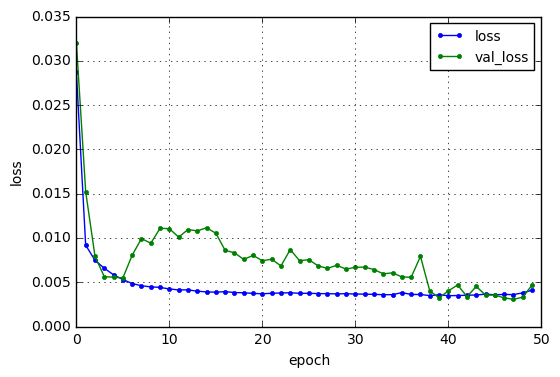

this data had finished making
_AEdim=016_Win=0512_Sld=0064_Adam_Sparse_L1=0.0001_L2=000.0
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
2s - loss: 0.0417 - val_loss: 0.0539
Epoch 2/50
2s - loss: 0.0182 - val_loss: 0.0331
Epoch 3/50
2s - loss: 0.0123 - val_loss: 0.0323
Epoch 4/50
2s - loss: 0.0117 - val_loss: 0.0339
Epoch 5/50
2s - loss: 0.0112 - val_loss: 0.0352
Epoch 6/50
2s - loss: 0.0107 - val_loss: 0.0329
Epoch 7/50
2s - loss: 0.0103 - val_loss: 0.0272
Epoch 8/50
2s - loss: 0.0092 - val_loss: 0.0286
Epoch 9/50
2s - loss: 0.0101 - val_loss: 0.0269
Epoch 10/50
2s - loss: 0.0095 - val_loss: 0.0216
Epoch 11/50
2s - loss: 0.0089 - val_loss: 0.0216
Epoch 12/50
2s - loss: 0.0087 - val_loss: 0.0201
Epoch 13/50
1s - loss: 0.0083 - val_loss: 0.0285
Epoch 14/50
1s - loss: 0.0086 - val_loss: 0.0191
Epoch 15/50
2s - loss: 0.0089 - val_loss: 0.0277
Epoch 16/50
2s - loss: 0.0092 - val_loss: 0.0267
Epoch 17/50
2s - loss: 0.0095 - val_loss: 0.0281
Epoch 18/50
2s - loss: 0.0089 - val_

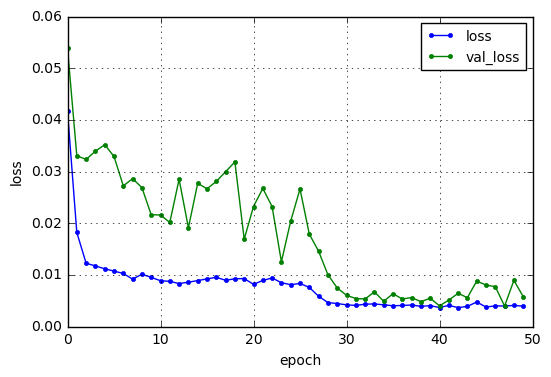

this data had finished making
_AEdim=016_Win=1024_Sld=0128_Adam_Sparse_L1=0.0001_L2=000.0
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
1s - loss: 0.0605 - val_loss: 0.0250
Epoch 2/50
1s - loss: 0.0371 - val_loss: 0.0259
Epoch 3/50
1s - loss: 0.0361 - val_loss: 0.0243
Epoch 4/50
1s - loss: 0.0376 - val_loss: 0.0329
Epoch 5/50
0s - loss: 0.0480 - val_loss: 0.0386
Epoch 6/50
1s - loss: 0.0355 - val_loss: 0.0350
Epoch 7/50
1s - loss: 0.0421 - val_loss: 0.0309
Epoch 8/50
1s - loss: 0.0366 - val_loss: 0.0428
Epoch 9/50
0s - loss: 0.0385 - val_loss: 0.0463
Epoch 10/50
0s - loss: 0.0413 - val_loss: 0.0617
Epoch 11/50
0s - loss: 0.0378 - val_loss: 0.0176
Epoch 12/50
1s - loss: 0.0259 - val_loss: 0.0623
Epoch 13/50
1s - loss: 0.0295 - val_loss: 0.0193
Epoch 14/50
1s - loss: 0.0296 - val_loss: 0.0263
Epoch 15/50
1s - loss: 0.0316 - val_loss: 0.0179
Epoch 16/50
1s - loss: 0.0400 - val_loss: 0.0549
Epoch 17/50
1s - loss: 0.0289 - val_loss: 0.0167
Epoch 18/50
1s - loss: 0.0219 - val_lo

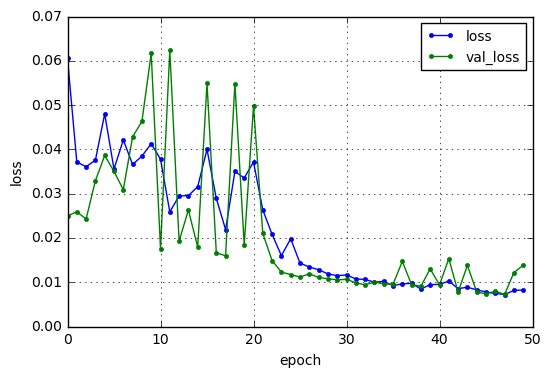

this data had finished making
_AEdim=016_Win=2048_Sld=0256_Adam_Sparse_L1=0.0001_L2=000.0
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.0882 - val_loss: 0.0630
Epoch 2/50
0s - loss: 0.0436 - val_loss: 0.0358
Epoch 3/50
0s - loss: 0.0543 - val_loss: 0.0465
Epoch 4/50
0s - loss: 0.0522 - val_loss: 0.0392
Epoch 5/50
0s - loss: 0.0591 - val_loss: 0.0591
Epoch 6/50
0s - loss: 0.0635 - val_loss: 0.0521
Epoch 7/50
0s - loss: 0.0611 - val_loss: 0.0569
Epoch 8/50
0s - loss: 0.0615 - val_loss: 0.0683
Epoch 9/50
0s - loss: 0.0568 - val_loss: 0.0758
Epoch 10/50
0s - loss: 0.0530 - val_loss: 0.0521
Epoch 11/50
0s - loss: 0.0614 - val_loss: 0.0713
Epoch 12/50
0s - loss: 0.0529 - val_loss: 0.0712
Epoch 13/50
0s - loss: 0.0564 - val_loss: 0.0482
Epoch 14/50
0s - loss: 0.0541 - val_loss: 0.0568
Epoch 15/50
0s - loss: 0.0567 - val_loss: 0.0708
Epoch 16/50
0s - loss: 0.0513 - val_loss: 0.0601
Epoch 17/50
0s - loss: 0.0560 - val_loss: 0.0662
Epoch 18/50
0s - loss: 0.0686 - val_lo

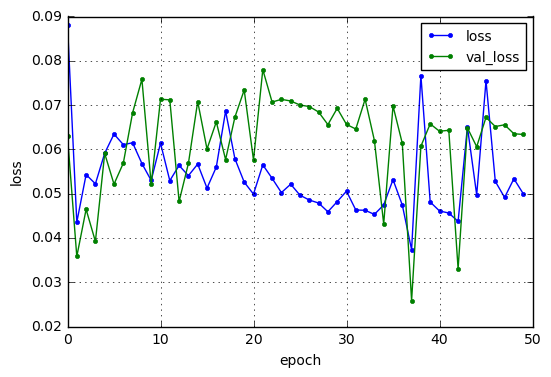

this data had finished making
_AEdim=016_Win=4096_Sld=0512_Adam_Sparse_L1=0.0001_L2=000.0
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.1198 - val_loss: 0.0630
Epoch 2/50
0s - loss: 0.0729 - val_loss: 0.0668
Epoch 3/50
0s - loss: 0.0604 - val_loss: 0.0653
Epoch 4/50
0s - loss: 0.0590 - val_loss: 0.0608
Epoch 5/50
0s - loss: 0.0590 - val_loss: 0.0598
Epoch 6/50
0s - loss: 0.0596 - val_loss: 0.0596
Epoch 7/50
0s - loss: 0.0572 - val_loss: 0.0585
Epoch 8/50
0s - loss: 0.0555 - val_loss: 0.0595
Epoch 9/50
0s - loss: 0.0614 - val_loss: 0.0655
Epoch 10/50
0s - loss: 0.0611 - val_loss: 0.0695
Epoch 11/50
0s - loss: 0.0635 - val_loss: 0.0811
Epoch 12/50
0s - loss: 0.0654 - val_loss: 0.0708
Epoch 13/50
0s - loss: 0.0735 - val_loss: 0.0730
Epoch 14/50
0s - loss: 0.0681 - val_loss: 0.0714
Epoch 15/50
0s - loss: 0.0657 - val_loss: 0.0663
Epoch 16/50
0s - loss: 0.0627 - val_loss: 0.0647
Epoch 17/50
0s - loss: 0.0612 - val_loss: 0.0667
Epoch 18/50
0s - loss: 0.0633 - val_lo

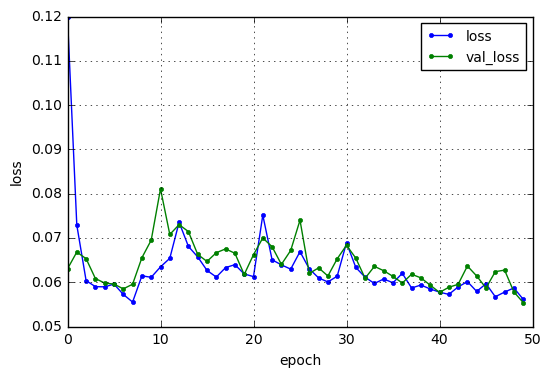

In [13]:
# loop windowWidth
WindowWidth = np.array( [256,512,1024,2048,4096] )
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='Adam'
AEDimention = 16
weightL1 = 10e-5
weightL2 = 0.0

for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
    
    CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowNum).zfill(4)+\
        '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim+\
        '_Sparse'+'_L1='+str(weightL1).zfill(5)+'_L2='+str(weightL2).zfill(5)
        
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    SparseAutoEncoder(windoW,windoW,AEDimention,Optim,CommonName,BatchSize,\
                     weightL1=weightL1,weightL2=weightL2)

# 検証内容2
L1Regularizerの効果と中間層の関係を検証してみる  
以下のパラメータで学習し結果を比較してみる  
L1 10e-5  
L2 0.0  

固定するパラメータ
* ウィンドウ幅 [256,512,1024,2048,4096]
* スライド幅 ウィンドウ幅/8
* バッチサイズ 32
* 最適化関数　adam
* 中間層の次元数 32

this data had finished making
_AEdim=032_Win=0256_Sld=0032_Adam_Sparse_L1=0.0001_L2=000.0
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
3s - loss: 0.0217 - val_loss: 0.0142
Epoch 2/50
4s - loss: 0.0083 - val_loss: 0.0083
Epoch 3/50
4s - loss: 0.0075 - val_loss: 0.0066
Epoch 4/50
3s - loss: 0.0066 - val_loss: 0.0207
Epoch 5/50
3s - loss: 0.0057 - val_loss: 0.0340
Epoch 6/50
3s - loss: 0.0053 - val_loss: 0.0293
Epoch 7/50
4s - loss: 0.0051 - val_loss: 0.0245
Epoch 8/50
4s - loss: 0.0047 - val_loss: 0.0261
Epoch 9/50
4s - loss: 0.0045 - val_loss: 0.0269
Epoch 10/50
4s - loss: 0.0044 - val_loss: 0.0201
Epoch 11/50
4s - loss: 0.0044 - val_loss: 0.0183
Epoch 12/50
4s - loss: 0.0041 - val_loss: 0.0163
Epoch 13/50
4s - loss: 0.0041 - val_loss: 0.0189
Epoch 14/50
4s - loss: 0.0042 - val_loss: 0.0189
Epoch 15/50
4s - loss: 0.0041 - val_loss: 0.0180
Epoch 16/50
4s - loss: 0.0039 - val_loss: 0.0216
Epoch 17/50
4s - loss: 0.0039 - val_loss: 0.0149
Epoch 18/50
4s - loss: 0.0039 - val_

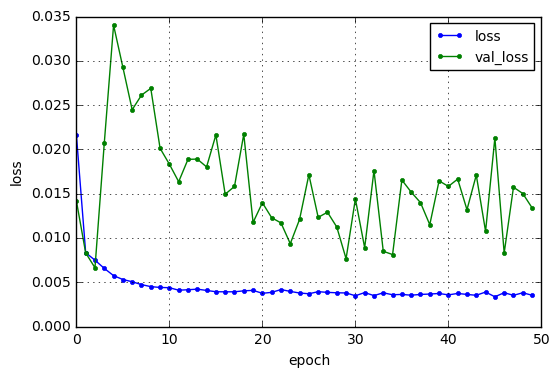

this data had finished making
_AEdim=032_Win=0512_Sld=0064_Adam_Sparse_L1=0.0001_L2=000.0
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
1s - loss: 0.0340 - val_loss: 0.0425
Epoch 2/50
1s - loss: 0.0125 - val_loss: 0.0363
Epoch 3/50
1s - loss: 0.0113 - val_loss: 0.0252
Epoch 4/50
1s - loss: 0.0102 - val_loss: 0.0211
Epoch 5/50
1s - loss: 0.0101 - val_loss: 0.0182
Epoch 6/50
1s - loss: 0.0101 - val_loss: 0.0190
Epoch 7/50
1s - loss: 0.0088 - val_loss: 0.0182
Epoch 8/50
1s - loss: 0.0061 - val_loss: 0.0164
Epoch 9/50
1s - loss: 0.0073 - val_loss: 0.0228
Epoch 10/50
1s - loss: 0.0062 - val_loss: 0.0178
Epoch 11/50
1s - loss: 0.0078 - val_loss: 0.0191
Epoch 12/50
1s - loss: 0.0074 - val_loss: 0.0197
Epoch 13/50
1s - loss: 0.0062 - val_loss: 0.0195
Epoch 14/50
1s - loss: 0.0055 - val_loss: 0.0142
Epoch 15/50
1s - loss: 0.0052 - val_loss: 0.0120
Epoch 16/50
1s - loss: 0.0051 - val_loss: 0.0142
Epoch 17/50
1s - loss: 0.0058 - val_loss: 0.0162
Epoch 18/50
1s - loss: 0.0053 - val_

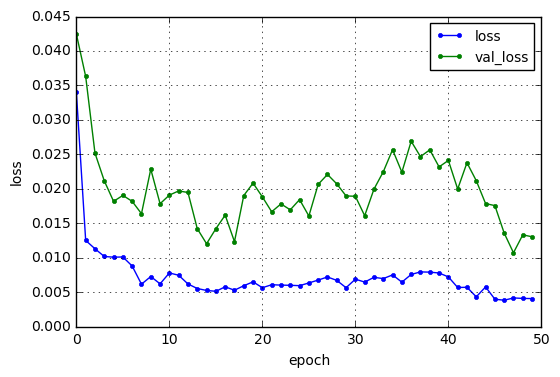

this data had finished making
_AEdim=032_Win=1024_Sld=0128_Adam_Sparse_L1=0.0001_L2=000.0
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.0450 - val_loss: 0.0133
Epoch 2/50
0s - loss: 0.0345 - val_loss: 0.0262
Epoch 3/50
0s - loss: 0.0382 - val_loss: 0.0334
Epoch 4/50
0s - loss: 0.0416 - val_loss: 0.0373
Epoch 5/50
0s - loss: 0.0356 - val_loss: 0.0305
Epoch 6/50
0s - loss: 0.0317 - val_loss: 0.0318
Epoch 7/50
0s - loss: 0.0384 - val_loss: 0.0348
Epoch 8/50
0s - loss: 0.0369 - val_loss: 0.0424
Epoch 9/50
0s - loss: 0.0342 - val_loss: 0.0267
Epoch 10/50
0s - loss: 0.0382 - val_loss: 0.0472
Epoch 11/50
0s - loss: 0.0371 - val_loss: 0.0364
Epoch 12/50
0s - loss: 0.0353 - val_loss: 0.0263
Epoch 13/50
0s - loss: 0.0364 - val_loss: 0.0463
Epoch 14/50
0s - loss: 0.0372 - val_loss: 0.0470
Epoch 15/50
0s - loss: 0.0373 - val_loss: 0.0494
Epoch 16/50
0s - loss: 0.0344 - val_loss: 0.0494
Epoch 17/50
0s - loss: 0.0329 - val_loss: 0.0289
Epoch 18/50
0s - loss: 0.0317 - val_lo

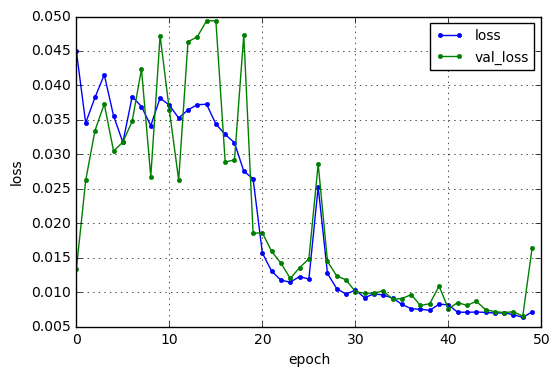

this data had finished making
_AEdim=032_Win=2048_Sld=0256_Adam_Sparse_L1=0.0001_L2=000.0
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.0738 - val_loss: 0.0485
Epoch 2/50
0s - loss: 0.0463 - val_loss: 0.0357
Epoch 3/50
0s - loss: 0.0508 - val_loss: 0.0409
Epoch 4/50
0s - loss: 0.0488 - val_loss: 0.0521
Epoch 5/50
0s - loss: 0.0456 - val_loss: 0.0332
Epoch 6/50
0s - loss: 0.0467 - val_loss: 0.0382
Epoch 7/50
0s - loss: 0.0539 - val_loss: 0.0579
Epoch 8/50
0s - loss: 0.0495 - val_loss: 0.0497
Epoch 9/50
0s - loss: 0.0525 - val_loss: 0.0566
Epoch 10/50
0s - loss: 0.0514 - val_loss: 0.0521
Epoch 11/50
0s - loss: 0.0478 - val_loss: 0.0424
Epoch 12/50
0s - loss: 0.0594 - val_loss: 0.0500
Epoch 13/50
0s - loss: 0.0511 - val_loss: 0.0550
Epoch 14/50
0s - loss: 0.0648 - val_loss: 0.0502
Epoch 15/50
0s - loss: 0.0515 - val_loss: 0.0534
Epoch 16/50
0s - loss: 0.0490 - val_loss: 0.0614
Epoch 17/50
0s - loss: 0.0502 - val_loss: 0.0569
Epoch 18/50
0s - loss: 0.0479 - val_lo

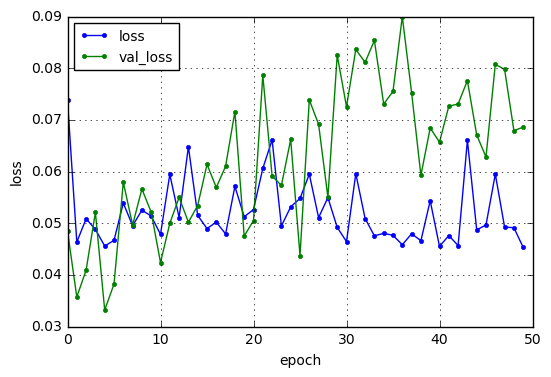

this data had finished making
_AEdim=032_Win=4096_Sld=0512_Adam_Sparse_L1=0.0001_L2=000.0
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.1037 - val_loss: 0.0645
Epoch 2/50
0s - loss: 0.0573 - val_loss: 0.0591
Epoch 3/50
0s - loss: 0.0561 - val_loss: 0.0601
Epoch 4/50
0s - loss: 0.0494 - val_loss: 0.0671
Epoch 5/50
0s - loss: 0.0576 - val_loss: 0.0565
Epoch 6/50
0s - loss: 0.0514 - val_loss: 0.0659
Epoch 7/50
0s - loss: 0.0516 - val_loss: 0.0623
Epoch 8/50
0s - loss: 0.0525 - val_loss: 0.0635
Epoch 9/50
0s - loss: 0.0555 - val_loss: 0.0597
Epoch 10/50
0s - loss: 0.0537 - val_loss: 0.0648
Epoch 11/50
0s - loss: 0.0564 - val_loss: 0.0623
Epoch 12/50
0s - loss: 0.0560 - val_loss: 0.0655
Epoch 13/50
0s - loss: 0.0532 - val_loss: 0.0662
Epoch 14/50
0s - loss: 0.0551 - val_loss: 0.0729
Epoch 15/50
0s - loss: 0.0540 - val_loss: 0.0636
Epoch 16/50
0s - loss: 0.0529 - val_loss: 0.0662
Epoch 17/50
0s - loss: 0.0511 - val_loss: 0.0620
Epoch 18/50
0s - loss: 0.0500 - val_lo

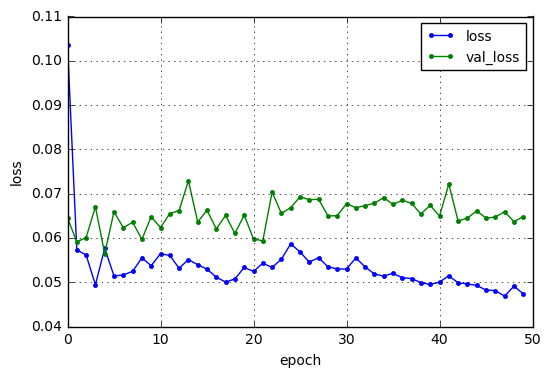

In [14]:
# loop windowWidth
WindowWidth = np.array( [256,512,1024,2048,4096] )
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='Adam'
AEDimention = 32
weightL1 = 10e-5
weightL2 = 0.0

for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
    
    CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowNum).zfill(4)+\
        '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim+\
        '_Sparse'+'_L1='+str(weightL1).zfill(5)+'_L2='+str(weightL2).zfill(5)
        
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    SparseAutoEncoder(windoW,windoW,AEDimention,Optim,CommonName,BatchSize,\
                     weightL1=weightL1,weightL2=weightL2)

# 検証内容3
L1Regularizerの効果を検証してみる  
以下のパラメータで学習し結果を比較してみる  
L1 10e-5  
L2 0.0  

固定するパラメータ
* ウィンドウ幅 [256,512,1024,2048,4096]
* スライド幅 ウィンドウ幅/8
* バッチサイズ 32
* 最適化関数　adam
* 中間層の次元数 64

this data had finished making
_AEdim=064_Win=0256_Sld=0032_Adam_Sparse_L1=0.0001_L2=000.0
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
2s - loss: 0.0174 - val_loss: 0.0112
Epoch 2/50
2s - loss: 0.0076 - val_loss: 0.0286
Epoch 3/50
2s - loss: 0.0071 - val_loss: 0.0396
Epoch 4/50
2s - loss: 0.0064 - val_loss: 0.0431
Epoch 5/50
2s - loss: 0.0062 - val_loss: 0.0429
Epoch 6/50
2s - loss: 0.0055 - val_loss: 0.0445
Epoch 7/50
2s - loss: 0.0053 - val_loss: 0.0361
Epoch 8/50
1s - loss: 0.0048 - val_loss: 0.0353
Epoch 9/50
1s - loss: 0.0049 - val_loss: 0.0338
Epoch 10/50
1s - loss: 0.0049 - val_loss: 0.0332
Epoch 11/50
2s - loss: 0.0048 - val_loss: 0.0314
Epoch 12/50
2s - loss: 0.0047 - val_loss: 0.0320
Epoch 13/50
2s - loss: 0.0049 - val_loss: 0.0257
Epoch 14/50
2s - loss: 0.0044 - val_loss: 0.0310
Epoch 15/50
2s - loss: 0.0048 - val_loss: 0.0300
Epoch 16/50
2s - loss: 0.0041 - val_loss: 0.0290
Epoch 17/50
2s - loss: 0.0044 - val_loss: 0.0291
Epoch 18/50
2s - loss: 0.0043 - val_

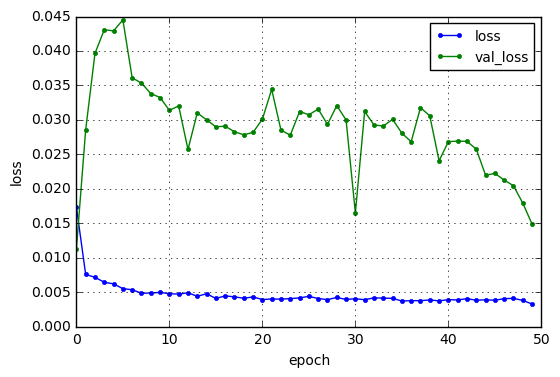

this data had finished making
_AEdim=064_Win=0512_Sld=0064_Adam_Sparse_L1=0.0001_L2=000.0
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
1s - loss: 0.0296 - val_loss: 0.0251
Epoch 2/50
1s - loss: 0.0117 - val_loss: 0.0200
Epoch 3/50
1s - loss: 0.0110 - val_loss: 0.0209
Epoch 4/50
1s - loss: 0.0109 - val_loss: 0.0138
Epoch 5/50
1s - loss: 0.0104 - val_loss: 0.0123
Epoch 6/50
1s - loss: 0.0089 - val_loss: 0.0138
Epoch 7/50
1s - loss: 0.0075 - val_loss: 0.0100
Epoch 8/50
1s - loss: 0.0060 - val_loss: 0.0088
Epoch 9/50
1s - loss: 0.0051 - val_loss: 0.0060
Epoch 10/50
1s - loss: 0.0048 - val_loss: 0.0046
Epoch 11/50
1s - loss: 0.0044 - val_loss: 0.0069
Epoch 12/50
1s - loss: 0.0038 - val_loss: 0.0072
Epoch 13/50
1s - loss: 0.0044 - val_loss: 0.0062
Epoch 14/50
1s - loss: 0.0036 - val_loss: 0.0052
Epoch 15/50
1s - loss: 0.0039 - val_loss: 0.0057
Epoch 16/50
1s - loss: 0.0041 - val_loss: 0.0076
Epoch 17/50
1s - loss: 0.0043 - val_loss: 0.0051
Epoch 18/50
1s - loss: 0.0034 - val_

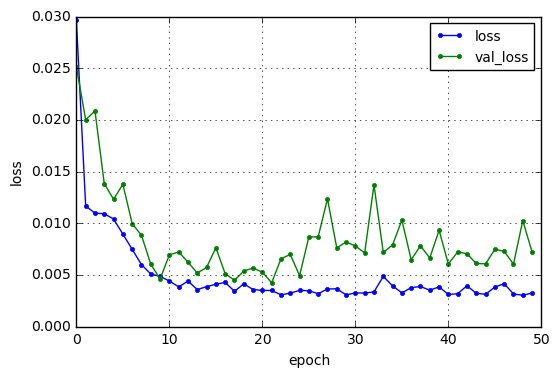

this data had finished making
_AEdim=064_Win=1024_Sld=0128_Adam_Sparse_L1=0.0001_L2=000.0
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.0368 - val_loss: 0.0127
Epoch 2/50
0s - loss: 0.0186 - val_loss: 0.0112
Epoch 3/50
0s - loss: 0.0165 - val_loss: 0.0101
Epoch 4/50
0s - loss: 0.0127 - val_loss: 0.0094
Epoch 5/50
0s - loss: 0.0106 - val_loss: 0.0094
Epoch 6/50
0s - loss: 0.0108 - val_loss: 0.0097
Epoch 7/50
0s - loss: 0.0105 - val_loss: 0.0094
Epoch 8/50
0s - loss: 0.0112 - val_loss: 0.0105
Epoch 9/50
0s - loss: 0.0121 - val_loss: 0.0096
Epoch 10/50
0s - loss: 0.0114 - val_loss: 0.0097
Epoch 11/50
0s - loss: 0.0116 - val_loss: 0.0100
Epoch 12/50
0s - loss: 0.0109 - val_loss: 0.0091
Epoch 13/50
0s - loss: 0.0114 - val_loss: 0.0099
Epoch 14/50
0s - loss: 0.0125 - val_loss: 0.0123
Epoch 15/50
0s - loss: 0.0130 - val_loss: 0.0186
Epoch 16/50
0s - loss: 0.0148 - val_loss: 0.0123
Epoch 17/50
0s - loss: 0.0180 - val_loss: 0.0259
Epoch 18/50
0s - loss: 0.0210 - val_lo

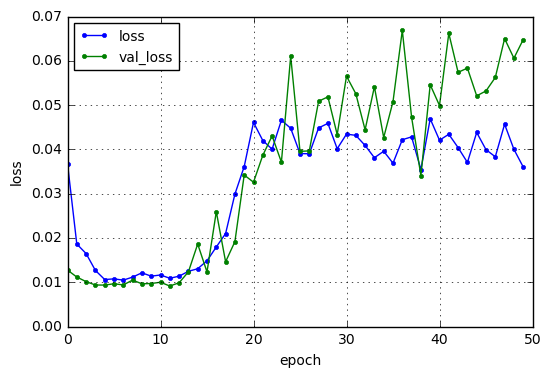

this data had finished making
_AEdim=064_Win=2048_Sld=0256_Adam_Sparse_L1=0.0001_L2=000.0
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.0625 - val_loss: 0.0365
Epoch 2/50
0s - loss: 0.0437 - val_loss: 0.0462
Epoch 3/50
0s - loss: 0.0469 - val_loss: 0.0403
Epoch 4/50
0s - loss: 0.0451 - val_loss: 0.0345
Epoch 5/50
0s - loss: 0.0481 - val_loss: 0.0441
Epoch 6/50
0s - loss: 0.0509 - val_loss: 0.0465
Epoch 7/50
0s - loss: 0.0442 - val_loss: 0.0454
Epoch 8/50
0s - loss: 0.0510 - val_loss: 0.0483
Epoch 9/50
0s - loss: 0.0499 - val_loss: 0.0415
Epoch 10/50
0s - loss: 0.0480 - val_loss: 0.0409
Epoch 11/50
0s - loss: 0.0469 - val_loss: 0.0380
Epoch 12/50
0s - loss: 0.0477 - val_loss: 0.0567
Epoch 13/50
0s - loss: 0.0573 - val_loss: 0.0436
Epoch 14/50
0s - loss: 0.0544 - val_loss: 0.0566
Epoch 15/50
0s - loss: 0.0516 - val_loss: 0.0558
Epoch 16/50
0s - loss: 0.0499 - val_loss: 0.0516
Epoch 17/50
0s - loss: 0.0510 - val_loss: 0.0425
Epoch 18/50
0s - loss: 0.0523 - val_lo

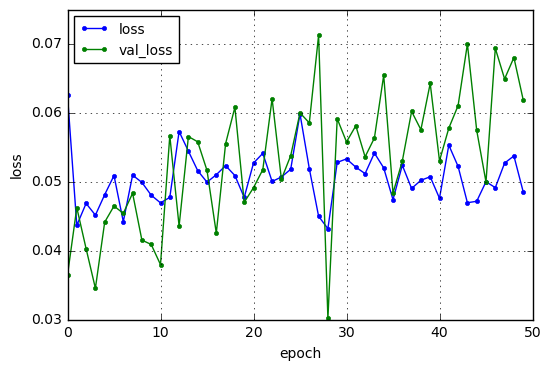

this data had finished making
_AEdim=064_Win=4096_Sld=0512_Adam_Sparse_L1=0.0001_L2=000.0
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.0995 - val_loss: 0.0652
Epoch 2/50
0s - loss: 0.0530 - val_loss: 0.0619
Epoch 3/50
0s - loss: 0.0531 - val_loss: 0.0653
Epoch 4/50
0s - loss: 0.0562 - val_loss: 0.0771
Epoch 5/50
0s - loss: 0.0532 - val_loss: 0.0765
Epoch 6/50
0s - loss: 0.0505 - val_loss: 0.0626
Epoch 7/50
0s - loss: 0.0508 - val_loss: 0.0659
Epoch 8/50
0s - loss: 0.0555 - val_loss: 0.0762
Epoch 9/50
0s - loss: 0.0489 - val_loss: 0.0709
Epoch 10/50
0s - loss: 0.0555 - val_loss: 0.0694
Epoch 11/50
0s - loss: 0.0533 - val_loss: 0.0821
Epoch 12/50
0s - loss: 0.0508 - val_loss: 0.0742
Epoch 13/50
0s - loss: 0.0545 - val_loss: 0.0803
Epoch 14/50
0s - loss: 0.0506 - val_loss: 0.0842
Epoch 15/50
0s - loss: 0.0512 - val_loss: 0.0824
Epoch 16/50
0s - loss: 0.0489 - val_loss: 0.0756
Epoch 17/50
0s - loss: 0.0524 - val_loss: 0.1119
Epoch 18/50
0s - loss: 0.0542 - val_lo

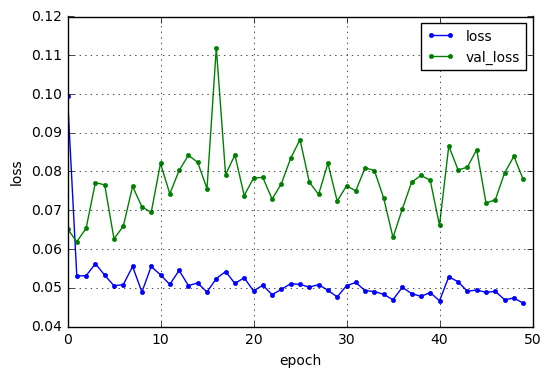

In [15]:
# loop windowWidth
WindowWidth = np.array( [256,512,1024,2048,4096] )
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='Adam'
AEDimention = 64
weightL1 = 10e-5
weightL2 = 0.0

for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
    
    CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowNum).zfill(4)+\
        '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim+\
        '_Sparse'+'_L1='+str(weightL1).zfill(5)+'_L2='+str(weightL2).zfill(5)
        
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    SparseAutoEncoder(windoW,windoW,AEDimention,Optim,CommonName,BatchSize,\
                     weightL1=weightL1,weightL2=weightL2)

# 検証内容4
L1Regularizerの効果と中間層の関係を検証してみる  
以下のパラメータで学習し結果を比較してみる  
L1 10e-5  
L2 0.0  

固定するパラメータ
* ウィンドウ幅 [256,512,1024,2048,4096]
* スライド幅 ウィンドウ幅/8
* バッチサイズ 32
* 最適化関数　adam
* 中間層の次元数 128

this data had finished making
_AEdim=128_Win=0256_Sld=0032_Adam_Sparse_L1=0.0001_L2=000.0
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
2s - loss: 0.0140 - val_loss: 0.0193
Epoch 2/50
2s - loss: 0.0077 - val_loss: 0.0331
Epoch 3/50
2s - loss: 0.0074 - val_loss: 0.0343
Epoch 4/50
2s - loss: 0.0065 - val_loss: 0.0221
Epoch 5/50
2s - loss: 0.0062 - val_loss: 0.0161
Epoch 6/50
2s - loss: 0.0055 - val_loss: 0.0153
Epoch 7/50
2s - loss: 0.0052 - val_loss: 0.0140
Epoch 8/50
2s - loss: 0.0046 - val_loss: 0.0093
Epoch 9/50
2s - loss: 0.0044 - val_loss: 0.0141
Epoch 10/50
2s - loss: 0.0040 - val_loss: 0.0186
Epoch 11/50
2s - loss: 0.0046 - val_loss: 0.0124
Epoch 12/50
2s - loss: 0.0039 - val_loss: 0.0140
Epoch 13/50
2s - loss: 0.0041 - val_loss: 0.0110
Epoch 14/50
2s - loss: 0.0039 - val_loss: 0.0100
Epoch 15/50
2s - loss: 0.0039 - val_loss: 0.0137
Epoch 16/50
1s - loss: 0.0042 - val_loss: 0.0108
Epoch 17/50
1s - loss: 0.0040 - val_loss: 0.0130
Epoch 18/50
2s - loss: 0.0037 - val_

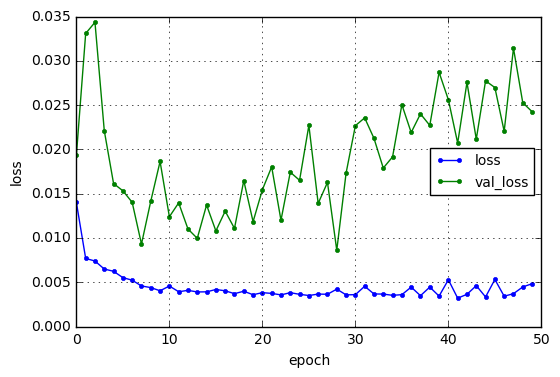

this data had finished making
_AEdim=128_Win=0512_Sld=0064_Adam_Sparse_L1=0.0001_L2=000.0
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
0s - loss: 0.0238 - val_loss: 0.0338
Epoch 2/50
0s - loss: 0.0083 - val_loss: 0.0290
Epoch 3/50
0s - loss: 0.0078 - val_loss: 0.0190
Epoch 4/50
1s - loss: 0.0072 - val_loss: 0.0093
Epoch 5/50
1s - loss: 0.0062 - val_loss: 0.0067
Epoch 6/50
1s - loss: 0.0051 - val_loss: 0.0078
Epoch 7/50
1s - loss: 0.0056 - val_loss: 0.0098
Epoch 8/50
1s - loss: 0.0050 - val_loss: 0.0059
Epoch 9/50
1s - loss: 0.0056 - val_loss: 0.0047
Epoch 10/50
1s - loss: 0.0048 - val_loss: 0.0110
Epoch 11/50
1s - loss: 0.0051 - val_loss: 0.0052
Epoch 12/50
1s - loss: 0.0052 - val_loss: 0.0125
Epoch 13/50
1s - loss: 0.0051 - val_loss: 0.0071
Epoch 14/50
1s - loss: 0.0042 - val_loss: 0.0053
Epoch 15/50
1s - loss: 0.0044 - val_loss: 0.0050
Epoch 16/50
1s - loss: 0.0047 - val_loss: 0.0184
Epoch 17/50
1s - loss: 0.0054 - val_loss: 0.0084
Epoch 18/50
1s - loss: 0.0039 - val_

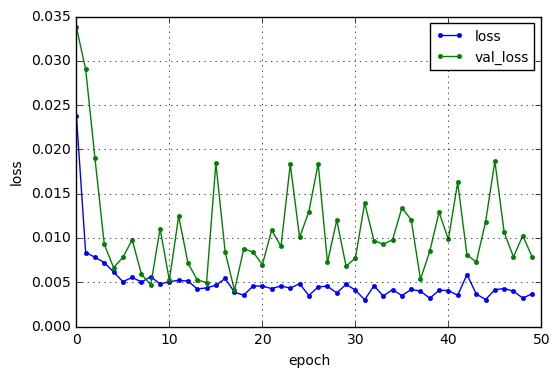

this data had finished making
_AEdim=128_Win=1024_Sld=0128_Adam_Sparse_L1=0.0001_L2=000.0
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.0359 - val_loss: 0.0104
Epoch 2/50
0s - loss: 0.0102 - val_loss: 0.0082
Epoch 3/50
0s - loss: 0.0091 - val_loss: 0.0080
Epoch 4/50
0s - loss: 0.0085 - val_loss: 0.0086
Epoch 5/50
0s - loss: 0.0086 - val_loss: 0.0099
Epoch 6/50
0s - loss: 0.0083 - val_loss: 0.0082
Epoch 7/50
0s - loss: 0.0086 - val_loss: 0.0142
Epoch 8/50
0s - loss: 0.0085 - val_loss: 0.0094
Epoch 9/50
0s - loss: 0.0077 - val_loss: 0.0079
Epoch 10/50
0s - loss: 0.0084 - val_loss: 0.0083
Epoch 11/50
0s - loss: 0.0085 - val_loss: 0.0074
Epoch 12/50
0s - loss: 0.0085 - val_loss: 0.0120
Epoch 13/50
0s - loss: 0.0078 - val_loss: 0.0070
Epoch 14/50
0s - loss: 0.0079 - val_loss: 0.0056
Epoch 15/50
0s - loss: 0.0077 - val_loss: 0.0056
Epoch 16/50
0s - loss: 0.0073 - val_loss: 0.0054
Epoch 17/50
0s - loss: 0.0078 - val_loss: 0.0071
Epoch 18/50
0s - loss: 0.0080 - val_lo

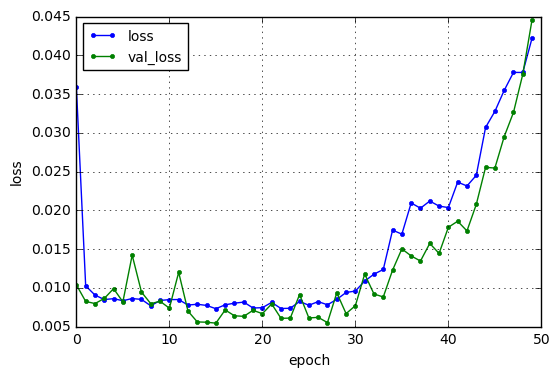

this data had finished making
_AEdim=128_Win=2048_Sld=0256_Adam_Sparse_L1=0.0001_L2=000.0
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.0603 - val_loss: 0.0282
Epoch 2/50
0s - loss: 0.0430 - val_loss: 0.0411
Epoch 3/50
0s - loss: 0.0500 - val_loss: 0.0392
Epoch 4/50
0s - loss: 0.0472 - val_loss: 0.0364
Epoch 5/50
0s - loss: 0.0472 - val_loss: 0.0350
Epoch 6/50
0s - loss: 0.0445 - val_loss: 0.0351
Epoch 7/50
0s - loss: 0.0504 - val_loss: 0.0377
Epoch 8/50
0s - loss: 0.0526 - val_loss: 0.0418
Epoch 9/50
0s - loss: 0.0546 - val_loss: 0.0453
Epoch 10/50
0s - loss: 0.0555 - val_loss: 0.0486
Epoch 11/50
0s - loss: 0.0540 - val_loss: 0.0445
Epoch 12/50
0s - loss: 0.0512 - val_loss: 0.0441
Epoch 13/50
0s - loss: 0.0567 - val_loss: 0.0455
Epoch 14/50
0s - loss: 0.0540 - val_loss: 0.0467
Epoch 15/50
0s - loss: 0.0494 - val_loss: 0.0417
Epoch 16/50
0s - loss: 0.0524 - val_loss: 0.0427
Epoch 17/50
0s - loss: 0.0515 - val_loss: 0.0462
Epoch 18/50
0s - loss: 0.0516 - val_lo

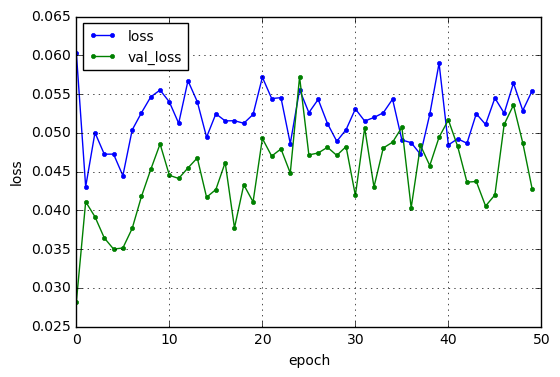

this data had finished making
_AEdim=128_Win=4096_Sld=0512_Adam_Sparse_L1=0.0001_L2=000.0
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.1036 - val_loss: 0.0724
Epoch 2/50
0s - loss: 0.0555 - val_loss: 0.0656
Epoch 3/50
0s - loss: 0.0540 - val_loss: 0.0606
Epoch 4/50
0s - loss: 0.0540 - val_loss: 0.0695
Epoch 5/50
0s - loss: 0.0545 - val_loss: 0.0677
Epoch 6/50
0s - loss: 0.0529 - val_loss: 0.0608
Epoch 7/50
0s - loss: 0.0525 - val_loss: 0.0715
Epoch 8/50
0s - loss: 0.0516 - val_loss: 0.0688
Epoch 9/50
0s - loss: 0.0549 - val_loss: 0.0706
Epoch 10/50
0s - loss: 0.0538 - val_loss: 0.0756
Epoch 11/50
0s - loss: 0.0558 - val_loss: 0.0803
Epoch 12/50
0s - loss: 0.0507 - val_loss: 0.0802
Epoch 13/50
0s - loss: 0.0490 - val_loss: 0.0715
Epoch 14/50
0s - loss: 0.0535 - val_loss: 0.0824
Epoch 15/50
0s - loss: 0.0526 - val_loss: 0.0774
Epoch 16/50
0s - loss: 0.0535 - val_loss: 0.0810
Epoch 17/50
0s - loss: 0.0517 - val_loss: 0.0820
Epoch 18/50
0s - loss: 0.0550 - val_lo

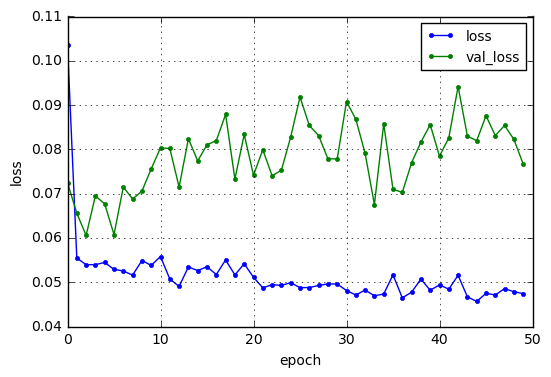

In [16]:
# loop windowWidth
WindowWidth = np.array( [256,512,1024,2048,4096] )
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='Adam'
AEDimention = 128
weightL1 = 10e-5
weightL2 = 0.0

for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
    
    CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowNum).zfill(4)+\
        '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim+\
        '_Sparse'+'_L1='+str(weightL1).zfill(5)+'_L2='+str(weightL2).zfill(5)
        
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    SparseAutoEncoder(windoW,windoW,AEDimention,Optim,CommonName,BatchSize,\
                     weightL1=weightL1,weightL2=weightL2)